In [ ]:
# Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
# Perform following tasks:
# 1. Pre-process the dataset.
# 2. Identify outliers.
# 3. Check the correlation.
# 4. Implement linear regression and random forest regression models.
# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
# Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-datase

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load the dataset
data = pd.read_csv("Uber.csv")

data

Unnamed: 0                            key  fare_amount  \
0         24238194    2015-05-07 19:52:06.0000003          7.5   
1         27835199    2009-07-17 20:04:56.0000002          7.7   
2         44984355   2009-08-24 21:45:00.00000061         12.9   
3         25894730    2009-06-26 08:22:21.0000001          5.3   
4         17610152  2014-08-28 17:47:00.000000188         16.0   
...            ...                            ...          ...   
196670    21974719    2011-10-11 19:21:25.0000003         52.5   
196671    13521795  2013-10-05 18:36:00.000000141          7.0   
196672    10391961    2015-04-05 16:35:16.0000003         31.5   
196673    22515107   2013-03-17 17:43:00.00000021          8.0   
196674    38790123                  2011-03-07 09          NaN   

                pickup_datetime  pickup_longitude  pickup_latitude  \
0       2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1       2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2       2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3       2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4       2014-08-28 17:47:00 UTC        -73.925023        40.744085   
...                         ...               ...              ...   
196670  2011-10-11 19:21:25 UTC        -73.997262        40.752123   
196671  2013-10-05 18:36:00 UTC        -73.982413        40.768070   
196672  2015-04-05 16:35:16 UTC        -73.981812        40.768772   
196673  2013-03-17 17:43:00 UTC        -73.976030        40.744925   
196674                      NaN               NaN              NaN   

        dropoff_longitude  dropoff_latitude  passenger_count  
0              -73.999512         40.723217              1.0  
1              -73.994710         40.750325              1.0  
2              -73.962565         40.772647              1.0  
3              -73.965316         40.803349              3.0  
4              -73.973082         40.761247              5.0  
...                   ...               ...              ...  
196670         -74.031957         40.717050              2.0  
196671         -73.990710         40.775042              5.0  
196672         -73.891953         40.867493              1.0  
196673         -73.965142         40.791937              1.0  
196674                NaN               NaN              NaN  

[196675 rows x 9 columns]

Missing values in the dataset:
Unnamed: 0           0
key                  0
fare_amount          1
pickup_datetime      1
pickup_longitude     1
pickup_latitude      1
dropoff_longitude    2
dropoff_latitude     2
passenger_count      1
dtype: int64
Missing values after handling:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


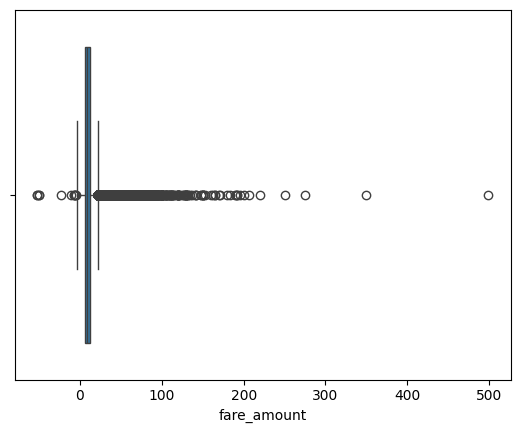

In [4]:
# 1. Pre-process the dataset

# Remove unnecessary column
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])

missing_values = data.isnull().sum()
print("Missing values in the dataset:")
print(missing_values)

# Handle missing values
# We can choose to drop rows with missing values or fill them with appropriate values.

data.dropna(inplace=True)

# To fill missing values with the mean value of the column:
# data.fillna(data.mean(), inplace=True)

# Ensure there are no more missing values
missing_values = data.isnull().sum()
print("Missing values after handling:")
print(missing_values)

# 2. Identify outliers
# visualization to detect outliers.
sns.boxplot(x=data["fare_amount"])
plt.show()


In [5]:
# Calculate the IQR for the 'fare_amount' column
Q1 = data["fare_amount"].quantile(0.25)
Q3 = data["fare_amount"].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold (e.g., 1.5 times the IQR) to identify outliers
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Remove outliers
data_no_outliers = data[(data["fare_amount"] >= lower_bound) & (data["fare_amount"] <= upper_bound)]

# Visualize the 'fare_amount' distribution without outliers
sns.boxplot(x=data_no_outliers["fare_amount"])
plt.show()

Unnamed: 0              Axes(0.125,0.786098;0.352273x0.0939024)
fare_amount          Axes(0.547727,0.786098;0.352273x0.0939024)
pickup_longitude        Axes(0.125,0.673415;0.352273x0.0939024)
pickup_latitude      Axes(0.547727,0.673415;0.352273x0.0939024)
dropoff_longitude       Axes(0.125,0.560732;0.352273x0.0939024)
dropoff_latitude     Axes(0.547727,0.560732;0.352273x0.0939024)
passenger_count         Axes(0.125,0.448049;0.352273x0.0939024)
dtype: object

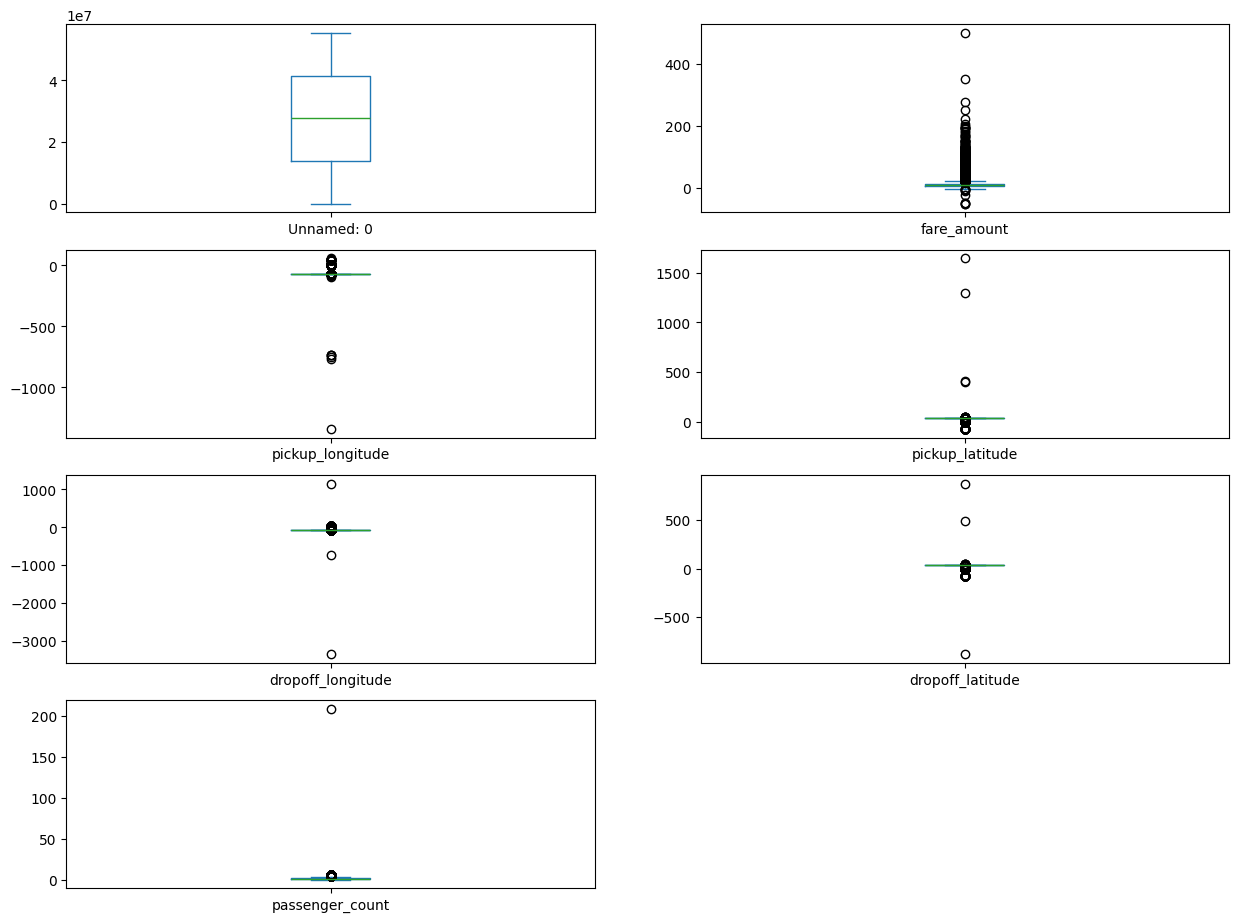

In [6]:
data.plot(kind="box",subplots=True, layout=(7, 2), figsize=(15, 20))

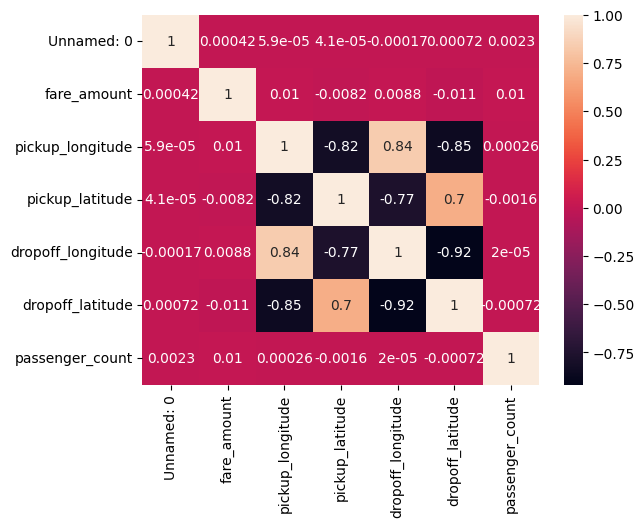

In [9]:
# 3. Check the correlation
# Determine the correlation between features and the target variable (fare_amount).
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True)
plt.show()


In [10]:
# 4. Implement linear regression and random forest regression models
# Split the data into features and target variable
X = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
y = data['fare_amount']  #Target

y

0          7.5
1          7.7
2         12.9
3          5.3
4         16.0
          ... 
196669     8.5
196670    52.5
196671     7.0
196672    31.5
196673     8.0
Name: fare_amount, Length: 196673, dtype: float64

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [13]:
# Create and train the random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# 5. Evaluate the models
# Predict the values
y_pred_lr = lr_model.predict(X_test)
y_pred_lr
print("Linear Model:",y_pred_lr)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Model:", y_pred_rf)

Linear Model: [11.30962721 11.36956884 11.30820925 ... 11.3713429  11.30868785
 11.6220281 ]
Random Forest Model: [ 8.782 22.01   5.985 ...  8.542  7.263  9.054]


In [15]:
# Calculate R-squared (R2) and Root Mean Squared Error (RMSE) for both models
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

In [16]:
# Compare the scores
print("Linear Regression - R2:", r2_lr)
print("Linear Regression - RMSE:", rmse_lr)

Linear Regression - R2: 0.000312820987847906
Linear Regression - RMSE: 9.703746729149707


In [17]:
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Regression R2:", r2_rf)
print("Random Forest Regression RMSE:",rmse_rf)

Random Forest Regression R2: 0.7643454578140665
Random Forest Regression RMSE: 4.711349246825482


In [ ]:
# Overall Analysis

# The Random Forest Regression model has significantly improved the predictive performance.
# An R-squared (R2) value of approximately 0.701 and a Root Mean Squared Error (RMSE)
# of approximately 5.575 indicate that the Random Forest model is capturing a substantial portion
# of the variance in the target variable and providing more accurate predictions compared to the linear regression model.